# Mount Google Drive and import PyTorch


In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

# Problem 1 - GRU for Sentiment Analysis

## Part 1 - Preprocessing

In [0]:
# Import required libraries and packages
import pandas as pd
import numpy as np
import nltk
import string
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import matplotlib.pyplot as plt

nltk.download('punkt')
print("Using torch version",torch.__version__)
USE_GPU = True


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Using torch version 1.0.1.post2


In [0]:
# Reading review data into lists
neg_train = []
pos_train = []
neg_test = []
pos_test = []

review_list = [neg_train,pos_train,neg_test,pos_test]

review_files = ["drive/Deep Learning/HW3/data/train_neg_merged.txt",
         "drive/Deep Learning/HW3/data/train_pos_merged.txt",
         "drive/Deep Learning/HW3/data/test_neg_merged.txt",
         "drive/Deep Learning/HW3/data/test_pos_merged.txt"]

translation = str.maketrans("","", string.punctuation);

for idx,filepath in enumerate(review_files):
  print("Loading",filepath,"...")
  with open(filepath) as fp:
      line = fp.readline()
      while line:
        line = line.replace("<br />"," ")
        line = line.translate(translation);
        line = line.lower()
        words = nltk.word_tokenize(line)
        review_list[idx].append(words)
        line = fp.readline()
      fp.close()
  print("Loaded",len(review_list[idx]),"reviews, beginning with",review_list[idx][0][:5])

Loading drive/Deep Learning/HW3/data/train_neg_merged.txt ...
Loaded 1500 reviews, beginning with ['today', 'i', 'found', 'they', 'all']
Loading drive/Deep Learning/HW3/data/train_pos_merged.txt ...
Loaded 1500 reviews, beginning with ['the', 'only', 'part', 'lacking', 'in']
Loading drive/Deep Learning/HW3/data/test_neg_merged.txt ...
Loaded 1500 reviews, beginning with ['any', 'of', 'law', 'orders', 'csi']
Loading drive/Deep Learning/HW3/data/test_pos_merged.txt ...
Loaded 1500 reviews, beginning with ['the', 'most', 'attractive', 'factor', 'that']


In [0]:
# Define a dictionary where we will map unique words to numbers
vocabulary = dict()
# Begin count at 2 so that we can use 1 for unseen words in test
# and have zeros be treated separately as padding
vocab_count = 2

for review in neg_train:
  for word in review:
    if word not in vocabulary:
      vocabulary[word] = vocab_count
      vocab_count += 1
      
for review in pos_train:
  for word in review:
    if word not in vocabulary:
      vocabulary[word] = vocab_count
      vocab_count += 1
      
# Vocabulary size includes 0 for padding and 1 for unseen words in test
VOCAB_SIZE = len(vocabulary)+2
print("Created a vocabulary with",VOCAB_SIZE,"words.")

Created a vocabulary with 35060 words.


In [0]:
# Function that will be used to vectorize the reviews
def vectorize_reviews(input_reviews):
  temp_list = []
  for review in input_reviews:
    temp_rep = np.zeros(400)
    fill_idx = 0
    if len(review) < 400:
      fill_idx = 400 - len(review)
    for word in review:
      if fill_idx < 400:
        if word in vocabulary:
          temp_rep[fill_idx] = vocabulary[word]
        else:
          temp_rep[fill_idx] = 1
        fill_idx += 1
    temp_list.append(temp_rep)
  return np.array(temp_list)

In [0]:
# Create arrays for vectorized review data
neg_train_arr = vectorize_reviews(neg_train)
pos_train_arr = vectorize_reviews(pos_train)
neg_test_arr = vectorize_reviews(neg_test)
pos_test_arr = vectorize_reviews(pos_test)

neg_labels = np.zeros(len(neg_train_arr))
pos_labels = np.ones(len(pos_train_arr))
labels = np.concatenate((neg_labels,pos_labels),axis=0)

train_x = np.concatenate((neg_train_arr,pos_train_arr),axis=0)
assert(np.array_equal(neg_train_arr[0],train_x[0]))
assert(np.array_equal(train_x[2999],pos_train_arr[1499]))

train_y = np.copy(labels)

test_x = np.concatenate((neg_test_arr,pos_test_arr),axis=0)
assert(np.array_equal(neg_test_arr[0],test_x[0]))
assert(np.array_equal(test_x[2999],pos_test_arr[1499]))

test_y = np.copy(labels)

In [0]:
# Create dataloader
batch_size = 100

train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_x),
                                           torch.from_numpy(train_y))
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_x),
                                           torch.from_numpy(test_y))
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False,
                                           batch_size=batch_size)


## Part 2 - Build A Binary Prediction RNN with GRU

In [0]:
# Create our binary prediction RNN with GRU model
class BinaryRNN(nn.Module):
  def __init__(self):
    super(BinaryRNN, self).__init__()
    self.embed = nn.Embedding(VOCAB_SIZE,128)
    self.gru = nn.GRU(128,128,num_layers=1,batch_first=True)
    self.dropout = nn.Dropout(p=0.5)
    self.linear = nn.Linear(128,1)
    
  def forward(self,x):
    if USE_GPU:
      x = self.embed(torch.tensor(x, dtype=torch.long).cuda())
    else:
      x = self.embed(torch.tensor(x, dtype=torch.long))
    x,h = self.gru(x)
    x = self.dropout(x[:,-1,:].squeeze())
    x = self.linear(x)
    x = torch.sigmoid(x)
    return(x,h)

net = BinaryRNN()
print(net)

BinaryRNN(
  (embed): Embedding(35060, 128)
  (gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.5)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [0]:
# Define loss function and optimizer
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.85)

In [0]:
# Define function to check binary prediction accuracy with confusion matrix
from sklearn.metrics import confusion_matrix

def check_accuracy(network):
  correct = 0
  total = 0
  y_pred = []
  y_true = []
  with torch.no_grad():
      for idx,data in enumerate(test_loader):
          reviews, labels = data
          reviews = reviews.to(device).type(torch.cuda.FloatTensor)
          labels = labels.to(device).type(torch.cuda.FloatTensor)
          outputs = network(reviews)[0]
          predicted = outputs.round()
          predicted = predicted.cpu().numpy().ravel()
          labels = labels.cpu().numpy().ravel()
          y_pred = np.concatenate((y_pred,predicted),axis=0)
          y_true = np.concatenate((y_true,labels),axis=0)
          if idx == 0:
            print("First predictions:",predicted.flatten())
            print("First labels:",labels)
          
          #print(predicted.type(),labels.type())
          total += len(labels)
          correct += (predicted == labels).sum()

          if idx % 5 == 0 or idx == 29:
            print("Test accuracy on first ",100*(idx+1),"reviews - ",
                (100 * correct / total))
            print("Correct = ",correct,", total = ",total)
  
  print(y_true,y_pred)
  cm = confusion_matrix(y_true,y_pred)
  print(cm)
  
  # Example docs: https://scikit-learn.org/stable/auto_examples/
  # model_selection/plot_confusion_matrix.html
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  classes = ['Negative','Positive']
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title="Confusion Matrix",
         ylabel='True label',
         xlabel='Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax

Beginning epoch  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Loss =  tensor(0.7076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  1
Beginning epoch  2
Beginning epoch  3
Beginning epoch  4
Beginning epoch  5
Loss =  tensor(0.6671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  6
Beginning epoch  7
Beginning epoch  8
Beginning epoch  9
Beginning epoch  10
Loss =  tensor(0.5755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  11
Beginning epoch  12
Beginning epoch  13
Beginning epoch  14
Beginning epoch  15
Loss =  tensor(0.3413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  16
Beginning epoch  17
Beginning epoch  18
Beginning epoch  19
Beginning epoch  20
Loss =  tensor(0.1358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  21
Beginning epoch  22
Beginning epoch  23
Beginning epoch  24
Beginning epoch  25
Loss =  tensor(0.0362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  26
Beginning epoch  27
B

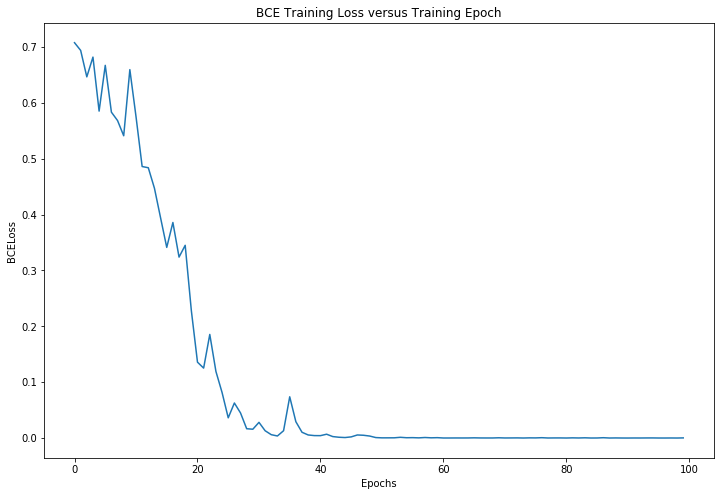

In [0]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #net = BinaryRNN()
  net.to(device)
else:
  device = "cpu"
 

epoch_accuracy = []
for epoch in range(100):  # loop over the dataset multiple times
  print("Beginning epoch ",epoch)

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    labels = labels.type(torch.FloatTensor)
    if USE_GPU:
      inputs, labels = inputs.to(device),labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs,h = net(inputs)
    
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  if(len(epoch_accuracy)%5 == 0):
    print("Loss = ",loss)
  epoch_accuracy.append(loss)

print('Finished Training')
plt.figure(figsize=(12,8)) 
plt.plot(epoch_accuracy)
plt.xlabel("Epochs")
plt.ylabel("BCELoss")
plt.title("BCE Training Loss versus Training Epoch")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


First predictions: [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0.]
First labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Test accuracy on first  100 reviews -  74.0
Correct =  74 , total =  100
Test accuracy on first  600 reviews -  69.66666666666667
Correct =  418 , total =  600
Test accuracy on first  1100 reviews -  69.72727272727273
Correct =  767 , total =  1100
Test accuracy on first  1600 reviews -  69.4375
Correct =  1111 , total =  1600
Test accuracy on first  21

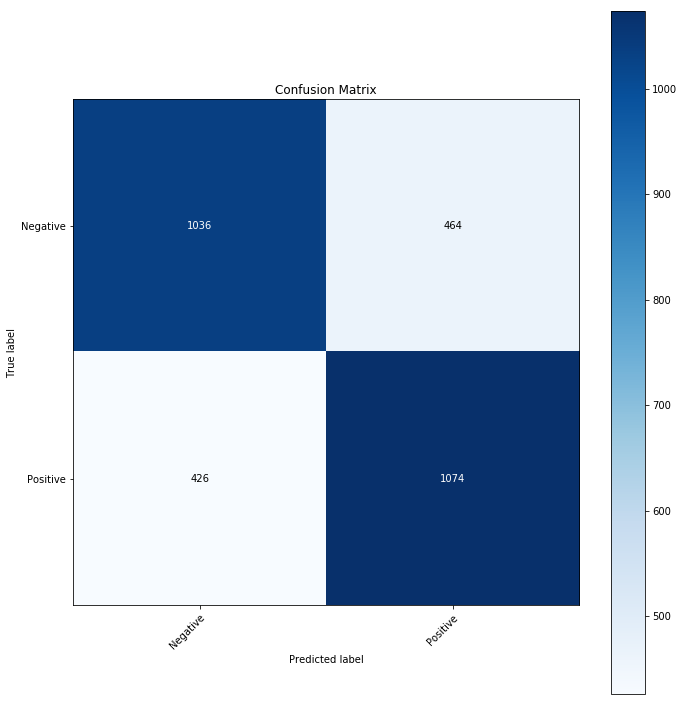

In [0]:
# Check accuracy of predictions from RNN against test set
check_accuracy(net)

## Part 3 - Comparison with a MLP 

In [0]:
# Define MLP model
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(400,1000)
    self.fc2 = nn.Linear(1000,64)
    self.fc3 = nn.Linear(64,1)
    
  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(x)
    return(x)
    
mlp_net = MLP()
print(mlp_net)
    

MLP(
  (fc1): Linear(in_features=400, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [0]:
# Define loss function and optimizer for mlp_net
import torch.optim as optim
mlp_net.to(device)
criterion = nn.BCELoss()
mlp_optimizer = optim.SGD(mlp_net.parameters(), lr=0.005, momentum=0.85)

Beginning epoch  0
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  1
Beginning epoch  2
Beginning epoch  3


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Beginning epoch  4
Beginning epoch  5
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  6
Beginning epoch  7
Beginning epoch  8
Beginning epoch  9
Beginning epoch  10
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  11
Beginning epoch  12
Beginning epoch  13
Beginning epoch  14
Beginning epoch  15
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  16
Beginning epoch  17
Beginning epoch  18
Beginning epoch  19
Beginning epoch  20
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  21
Beginning epoch  22
Beginning epoch  23
Beginning epoch  24
Beginning epoch  25
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
Beginning epoch  26
Beginning epoch  27
Beginning epoch  28
Beginning epoch  29
Beginning epoch  30
Loss =  tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>

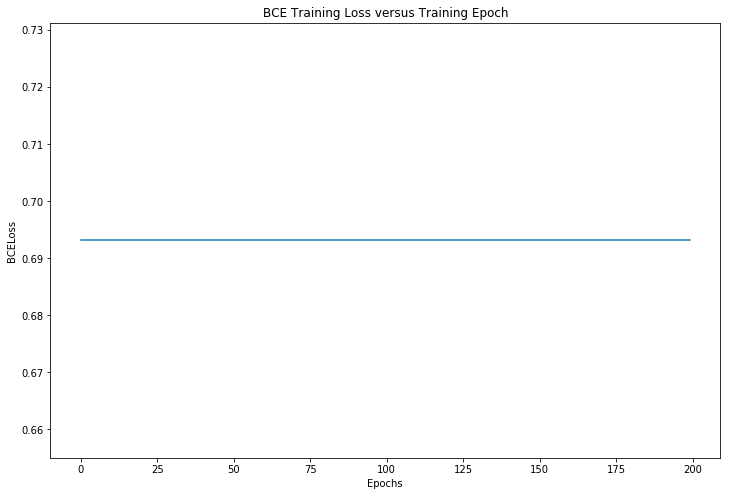

In [0]:

epoch_accuracy = []
for epoch in range(200):  # loop over the dataset multiple times
  print("Beginning epoch ",epoch)

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    labels = labels.type(torch.FloatTensor).to(device)
    inputs = inputs.type(torch.FloatTensor).to(device)

    # forward + backward + optimize
    outputs = mlp_net(inputs)
    loss = criterion(outputs, labels)
    # zero the parameter gradients
    mlp_optimizer.zero_grad()
    loss.backward()
    mlp_optimizer.step()

  if(len(epoch_accuracy)%5 == 0):
    print("Loss = ",loss)
  epoch_accuracy.append(loss)

print('Finished Training')
plt.figure(figsize=(12,8)) 
plt.plot(epoch_accuracy)
plt.xlabel("Epochs")
plt.ylabel("BCELoss")
plt.title("BCE Training Loss versus Training Epoch")
plt.show()

In [0]:
# Define function to check binary prediction accuracy with confusion matrix
from sklearn.metrics import confusion_matrix

def check_acc_mlp():
  correct = 0
  total = 0
  y_pred = []
  y_true = []
  print("DEBUG")
  with torch.no_grad():
      for idx,data in enumerate(test_loader):
          reviews, labels = data
          reviews = reviews.to(device).type(torch.cuda.FloatTensor)
          labels = labels.to(device).type(torch.cuda.FloatTensor)
          outputs = mlp_net(reviews)
          predicted = outputs.round()
          predicted = predicted.cpu().numpy().ravel()
          labels = labels.cpu().numpy().ravel()
          y_pred = np.concatenate((y_pred,predicted),axis=0)
          y_true = np.concatenate((y_true,labels),axis=0)
          if idx == 0:
            print("First predictions:",predicted)
            print("First labels:",labels)
          
          #print(predicted.type(),labels.type())
          total += len(labels)
          correct += (predicted == labels).sum()

          if idx % 5 == 0 or idx == 29:
            print("Test accuracy on first ",100*(idx+1),"reviews - ",
                (100 * correct / total))
            print("Correct = ",correct,", total = ",total)
  
  print(y_true,y_pred)
  cm = confusion_matrix(y_true,y_pred)
  print(cm)
  
  # Example docs: https://scikit-learn.org/stable/auto_examples/
  # model_selection/plot_confusion_matrix.html
  fig, ax = plt.subplots(1,1,figsize=(10,10))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  classes = ['Negative','Positive']
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title="Confusion Matrix",
         ylabel='True label',
         xlabel='Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax

DEBUG
First predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
First labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Test accuracy on first  100 reviews -  0.0
Correct =  0 , total =  100
Test accuracy on first  600 reviews -  0.0
Correct =  0 , total =  600
Test accuracy on first  1100 reviews -  0.0
Correct =  0 , total =  1100
Test accuracy on first  1600 reviews -  6.25
Correct =  100 , total =  1600
Test accuracy on first  2100 reviews -  28.571428571428573

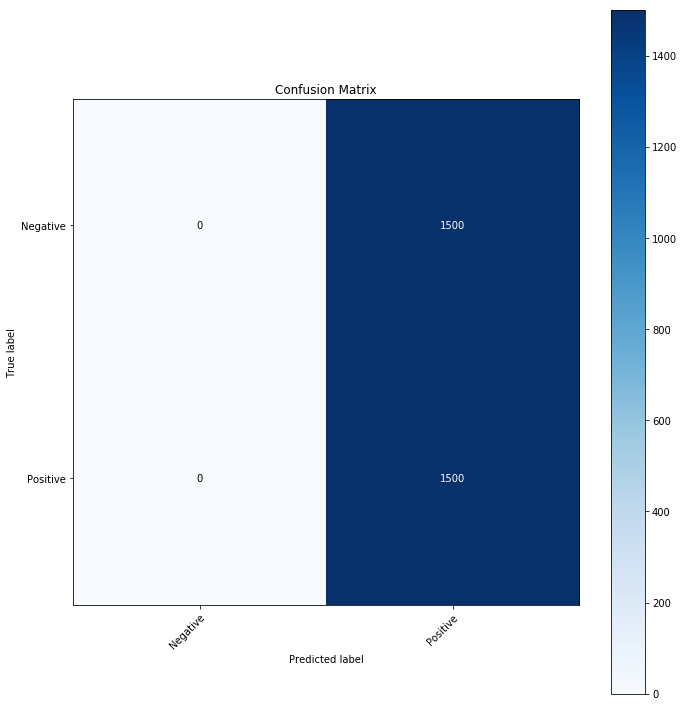

In [0]:
# Check accuracy of predictions from MLP against test set
check_acc_mlp()

# Problem 2 - Generative Adversarial Networks

In [9]:
# Import data set for FMNIST

import torchvision
from torchvision import transforms
from torchvision import utils
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 20

# Normalize data within transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])]) 

# Import FMNIST data set to data_loader
fmnist = torchvision.datasets.FashionMNIST(root="./",train=True,transform=transform,download=True)
data_loader = torch.utils.data.DataLoader(dataset=fmnist,batch_size=batch_size,shuffle=True)

print("Loaded",len(fmnist),"images from FMNIST training set.")

Loaded 60000 images from FMNIST training set.


In [0]:
# dataiter = iter(data_loader)
# images, labels = dataiter.next()

# print(images.shape)

# print(images.data[0].squeeze()[5])

# def imshow(img):
#     print(img.shape)
#     print(img.detach()[0][20])
#     img = img / 2 + 0.5     # unnormalize
#     print(img.detach()[0][20])
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
    
# imshow(torchvision.utils.make_grid(images))

## Part 1 - Vanilla GAN

In [0]:
# Define generator and discriminator models
class Generator(torch.nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    n_features = 100
    n_out = 784

    self.hidden0 = nn.Sequential(
      nn.Linear(n_features, 256),
      nn.LeakyReLU(0.2)
    )
    self.hidden1 = nn.Sequential(            
      nn.Linear(256, 512),
      nn.LeakyReLU(0.2)
    )
    self.hidden2 = nn.Sequential(
      nn.Linear(512, 1024),
      nn.LeakyReLU(0.2)
    )

    self.out = nn.Sequential(
      nn.Linear(1024, n_out),
      nn.Tanh()
    )

  def forward(self, x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x
      
class Discriminator(torch.nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    n_features = 784
    n_out = 1

    self.hidden0 = nn.Sequential( 
      nn.Linear(n_features, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3)
    )
    self.hidden1 = nn.Sequential(
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3)
    )
    self.hidden2 = nn.Sequential(
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3)
    )
    self.out = nn.Sequential(
      torch.nn.Linear(256, n_out),
      torch.nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

In [0]:
from torch.autograd import Variable
# Helper functions from this article:
# https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction
#                      -with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1, 28, 28)
  
def noise(size):
  n = Variable(torch.randn(size, 100))
  if torch.cuda.is_available(): return n.cuda() 
  print("Not using cuda for noise")
  return n

def real_data_target(size):
  '''
  Tensor containing ones, with shape = size
  '''
  data = Variable(torch.ones(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data

def fake_data_target(size):
  '''
  Tensor containing zeros, with shape = size
  '''
  data = Variable(torch.zeros(size, 1))
  if torch.cuda.is_available(): return data.cuda()
  return data

In [0]:
# Function to train descriminator and return loss
def train_discriminator(real_data, fake_data):
    real_target = real_data_target(batch_size)
    fake_target = fake_data_target(batch_size).detach()
    
    # Calculate error and backpropagate
    prediction_real = disc_model(real_data)
    real_loss = loss(prediction_real, real_target)

    # Calculate error and backpropagate
    prediction_fake = disc_model(fake_data)
    fake_loss = loss(prediction_fake, fake_target)
    
    # Reset discriminator gradients and update weights
    total_loss = real_loss + fake_loss
    disc_opt.zero_grad()  
    total_loss.backward()
    disc_opt.step()
      
    return total_loss

In [0]:
# Function to train the generator
def train_generator(fake_data):
    real_target = real_data_target(batch_size)
        
    # Calculate error and backpropagate
    prediction = disc_model(fake_data)
    train_loss = loss(prediction, real_target)
    
    # Update generator weights with gradients
    gen_opt.zero_grad()
    train_loss.backward()
    gen_opt.step()

    return train_loss

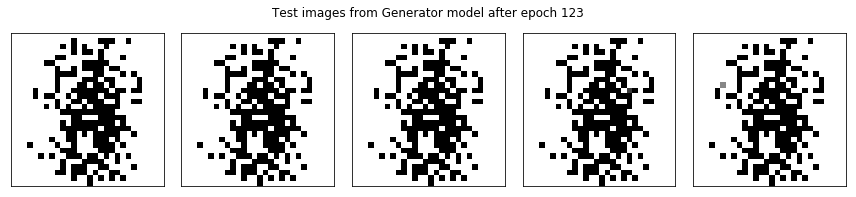

In [15]:
def show_test_images(num_images, epoch=None):
  # Defining pyplot parameters
  rows = (num_images/5)
  if num_images%5 > 0:
    rows += 1
  cols = 5
  fig,ax = plt.subplots(int(rows),int(cols),figsize=(12,12))
  if epoch == None:
    title = "Test images from Generator model"
    filename = "manually_generated_epochs"
  else:
    title = "Test images from Generator model after epoch "+str(epoch)
    filename = "drive/Deep Learning/HW3/images/generated_epochs_"+str(epoch)
  fig.suptitle(title,x=0.5,y=0.62)
    
  noise_data = noise(num_images)
  noise_images = gen_model(noise_data)
    
  for index,noise_img in enumerate(noise_images):
    plt.subplot(rows,cols,index+1)
    plt.xticks([])
    plt.yticks([])
    
    noise_img = noise_img / 2 + 0.5     # unnormalize    
    npimg = noise_img.cpu().detach().numpy().reshape((28,28))
    plt.imshow(npimg,cmap='Greys')
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()
      
def plot_errors(err1, err2):
  filename="drive/Deep Learning/HW3/images/errors_per_epoch_vanilla_"+str(len(err1))
  x_axis = np.arange(0,len(err1))
  plt.plot(x_axis,err1,label="Discriminator")
  plt.plot(x_axis,err2,label="Generator")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.title("BCELoss per epoch for Vanilla GAN")
  plt.savefig(filename)
  plt.show()
  
show_test_images(5,123)

Loading models on GPU cuda:0
Last generator error - tensor(10.4071, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0.1891, device='cuda:0', grad_fn=<DivBackward0>)


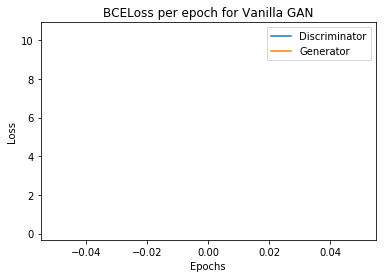

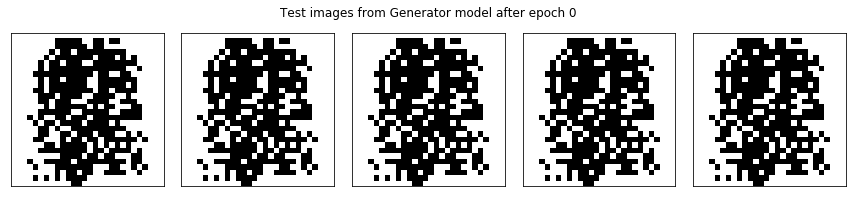

Last generator error - tensor(57.1588, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(3.0345e-07, device='cuda:0', grad_fn=<DivBackward0>)


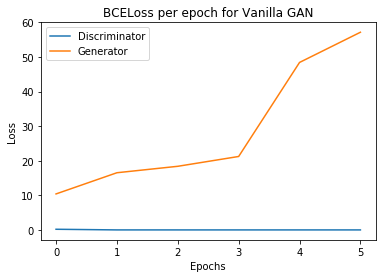

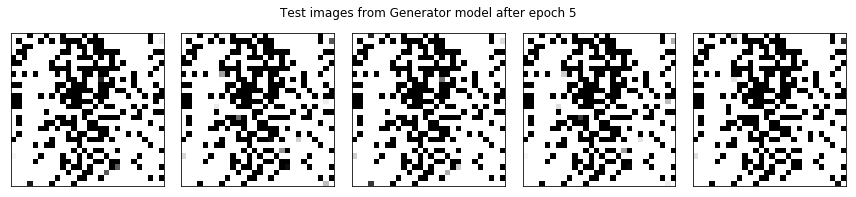

Last generator error - tensor(64.7627, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(1.1623e-09, device='cuda:0', grad_fn=<DivBackward0>)


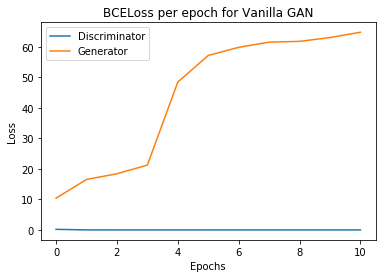

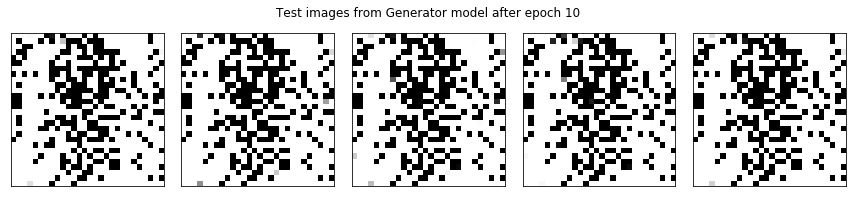

Last generator error - tensor(68.8611, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(3.9736e-12, device='cuda:0', grad_fn=<DivBackward0>)


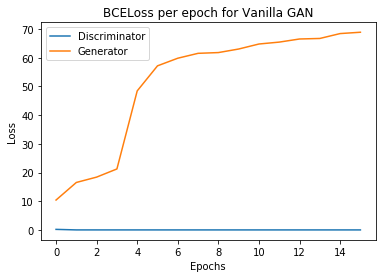

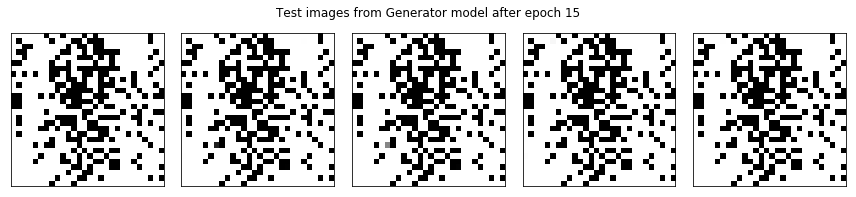

Last generator error - tensor(68.9813, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


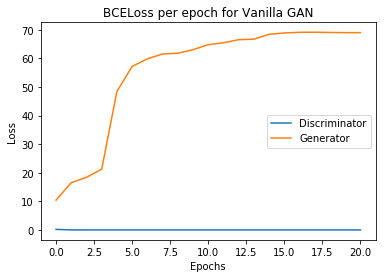

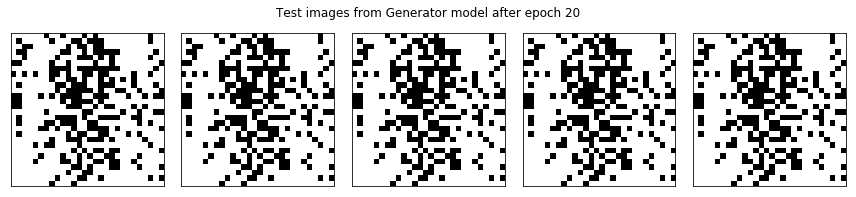

Last generator error - tensor(69.0149, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


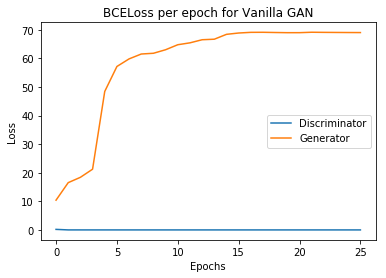

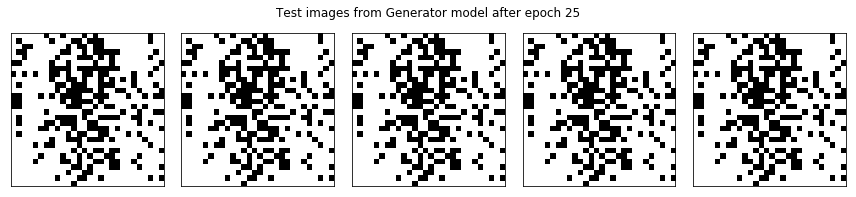

Last generator error - tensor(69.0728, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(3.9736e-12, device='cuda:0', grad_fn=<DivBackward0>)


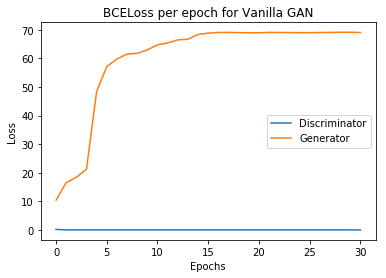

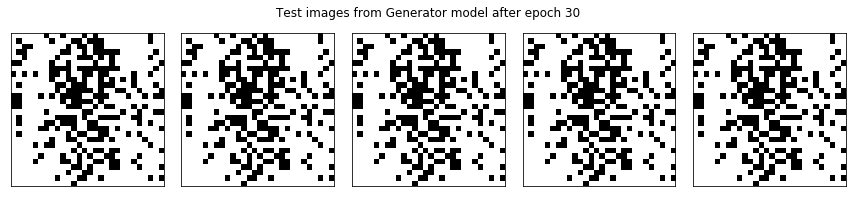

Last generator error - tensor(69.1227, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


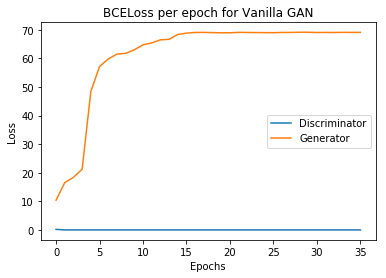

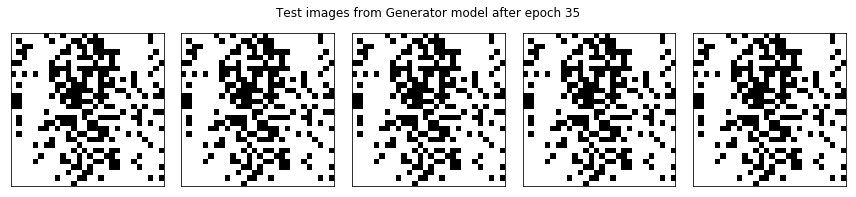

Last generator error - tensor(69.1802, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


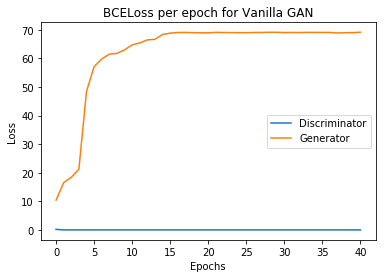

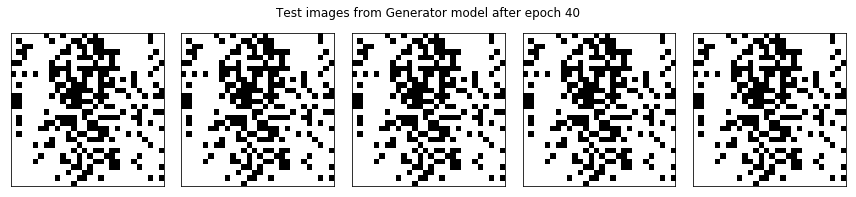

Last generator error - tensor(68.9678, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(1.9868e-12, device='cuda:0', grad_fn=<DivBackward0>)


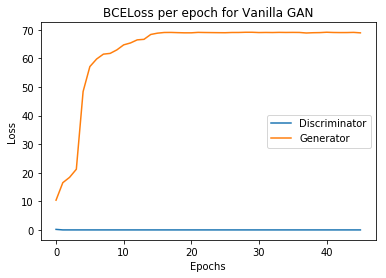

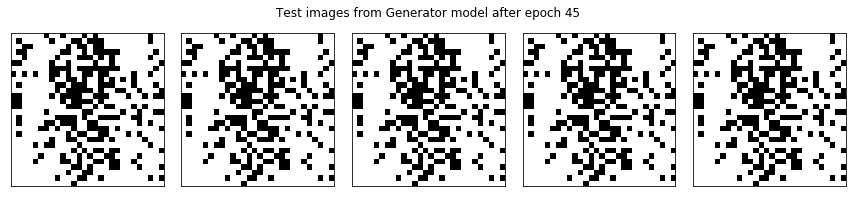

Last generator error - tensor(69.0975, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


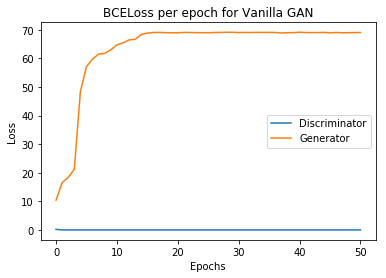

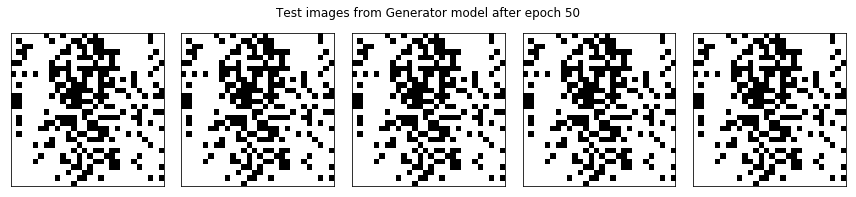

Last generator error - tensor(68.9682, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


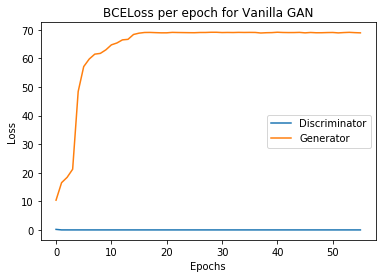

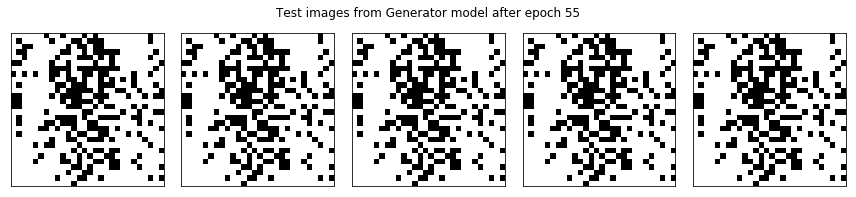

Last generator error - tensor(69.0169, device='cuda:0', grad_fn=<DivBackward0>)
Last discriminator error = tensor(0., device='cuda:0', grad_fn=<DivBackward0>)


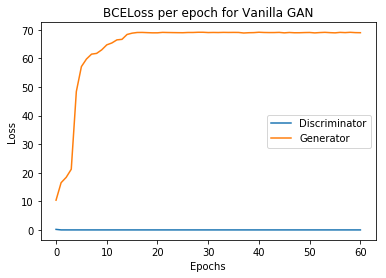

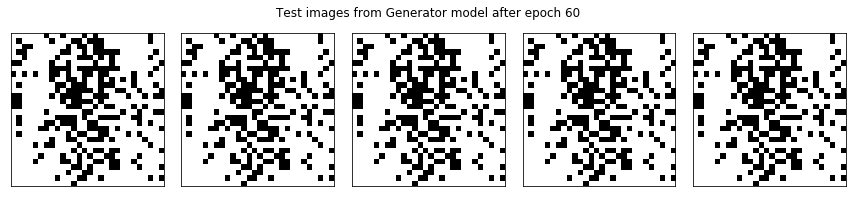

In [0]:
# Train the models
# Total number of epochs to train
num_epochs = 200

gen_error = []
disc_error = []

temp_disc_err = 0
temp_gen_err = 0
temp_err_cnt = 0

gen_model = Generator()
disc_model = Discriminator()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Loading models on GPU",device)
gen_model.to(device)
disc_model.to(device)

# Defining loss function and optimizers
loss = nn.BCELoss()
gen_opt = optim.Adam(gen_model.parameters(), lr=0.0002)
disc_opt = optim.Adam(disc_model.parameters(), lr=0.0002)
 
  
for epoch in range(num_epochs):
  temp_disc_err = 0
  temp_gen_err = 0
  temp_err_cnt = 0
  
  for n_batch, (real_batch,_) in enumerate(data_loader):
    # train discriminator
    fake_noise = noise(batch_size)
    fake_data = gen_model(fake_noise).to(device)    
    real_data = Variable(images_to_vectors(real_batch)).to(device)
    disc_err = train_discriminator(real_data, fake_data)
    temp_disc_err += disc_err

    # train generator
    #fake_noise = noise(batch_size)      
    fake_data = gen_model(fake_noise).to(device)
    gen_err = train_generator(fake_data)
    temp_gen_err += gen_err
    temp_err_cnt += 1

  disc_error.append(temp_disc_err/temp_err_cnt)
  gen_error.append(temp_gen_err/temp_err_cnt)
  
  if (epoch) % 5 == 0 or epoch == (num_epochs-1): 
    print("Last generator error -",gen_error[-1])
    print("Last discriminator error =",disc_error[-1])
    plot_errors(disc_error,gen_error)
    show_test_images(5,epoch)

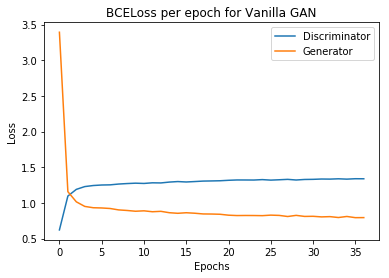

In [0]:
generated_images = gen

## Part 2 - GAN Loss

### MSE Loss

In [0]:
def show_model_images(num_images, show_model, model_name="GAN", epoch=None):
  # Defining pyplot parameters
  rows = (num_images/5)
  if num_images%5 > 0:
    rows += 1
  cols = 5
  fig,ax = plt.subplots(int(rows),int(cols),figsize=(12,12))
  if epoch == None:
    title = "Test images from Generator model"
    filename = "manually_generated_epochs"
  else:
    title = "Test images from "+model_name+" after epoch "+str(epoch)
    filename = "drive/Deep Learning/HW3/images/generated_epochs_"+model_name+str(epoch)
  fig.suptitle(title,x=0.5,y=0.62)
    
  noise_data = noise(num_images)
  noise_images = show_model(noise_data)
    
  for index,noise_img in enumerate(noise_images):
    plt.subplot(rows,cols,index+1)
    plt.xticks([])
    plt.yticks([])
    
    noise_img = noise_img / 2 + 0.5     # unnormalize    
    npimg = noise_img.cpu().detach().numpy().reshape((28,28))
    plt.imshow(npimg,cmap='Greys')
  plt.tight_layout()
  plt.savefig(filename)
  plt.show()
      
def plot_model_errors(err1, model_name="GAN"):
  filename="drive/Deep Learning/HW3/images/errors_"+model_name+str(len(err1))
  x_axis = np.arange(0,len(err1))
  plt.plot(x_axis,err1,label=model_name)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  title = "Loss per epoch for "+model_name
  plt.title(title)
  plt.savefig(filename)
  plt.show()

Epoch error:  tensor(0.3536, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3536, device='cuda:0', grad_fn=<DivBackward0>)


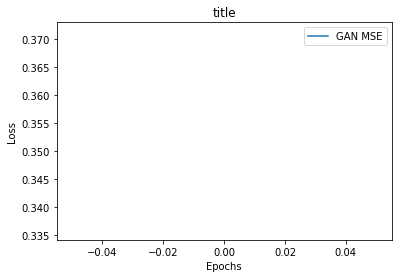

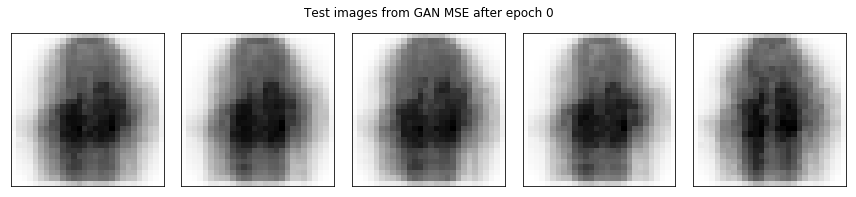

Epoch error:  tensor(0.3517, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3526, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3526, device='cuda:0', grad_fn=<DivBackward0>)


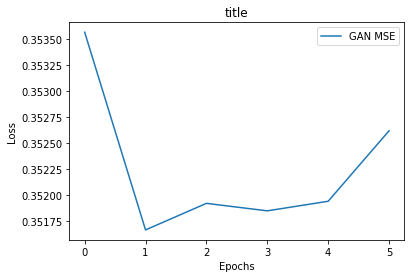

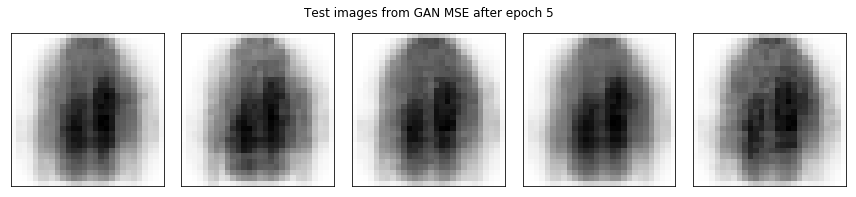

Epoch error:  tensor(0.3517, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)


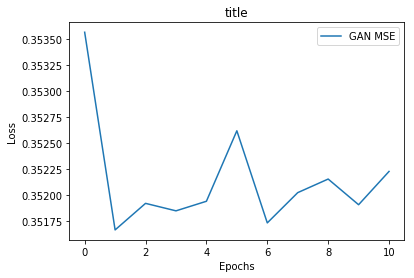

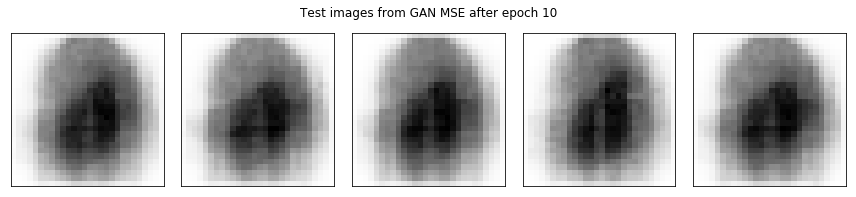

Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)


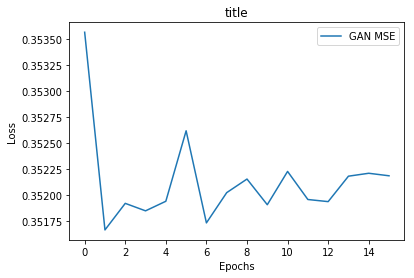

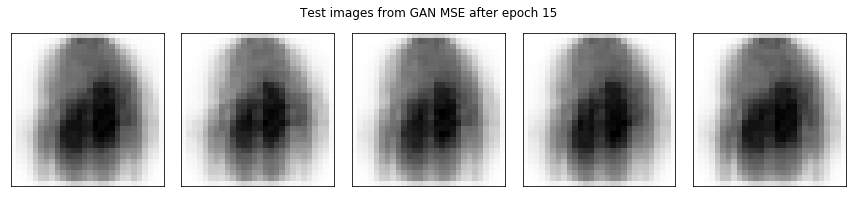

Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3524, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3524, device='cuda:0', grad_fn=<DivBackward0>)


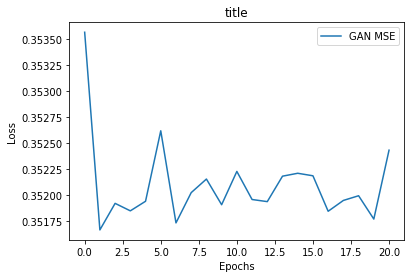

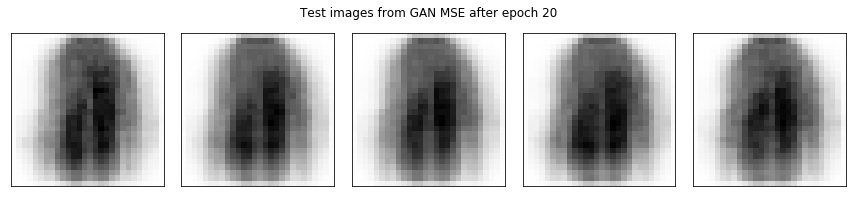

Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)


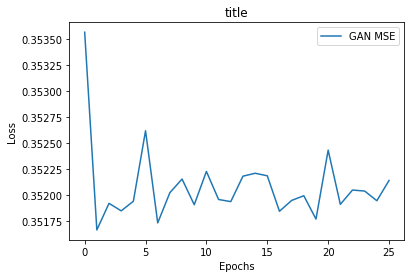

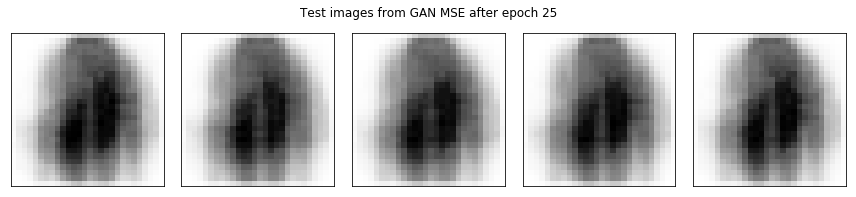

Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)


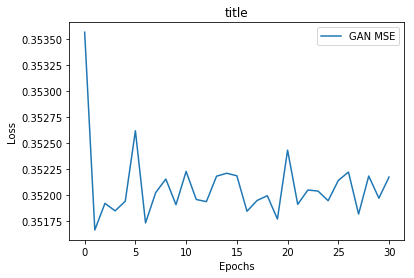

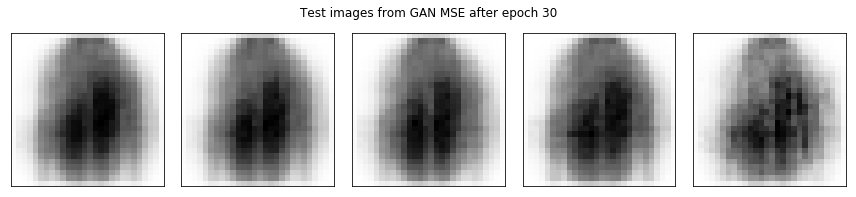

Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3523, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3517, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3517, device='cuda:0', grad_fn=<DivBackward0>)


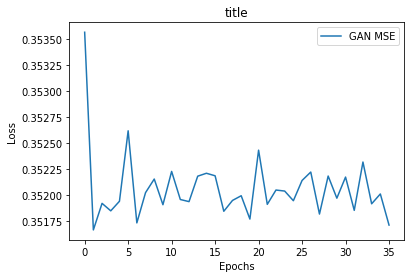

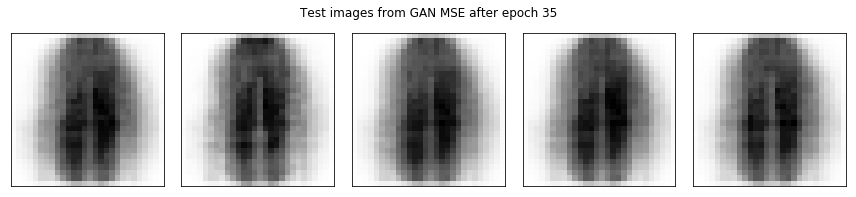

Epoch error:  tensor(0.3524, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3525, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)


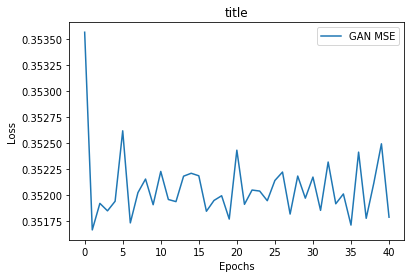

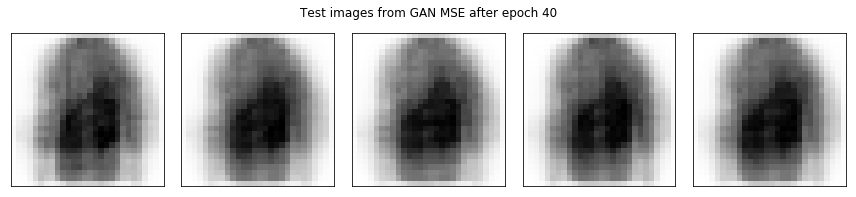

Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)


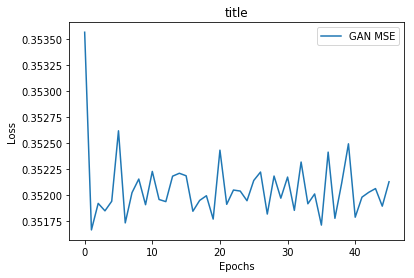

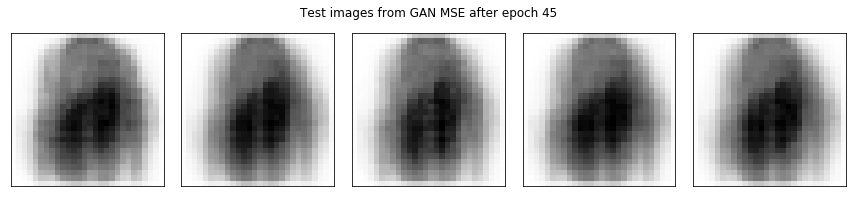

Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3526, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3526, device='cuda:0', grad_fn=<DivBackward0>)


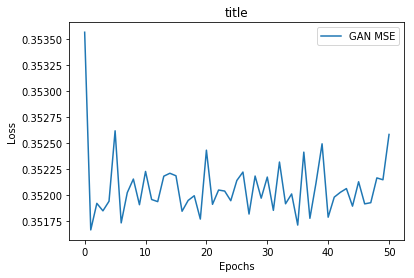

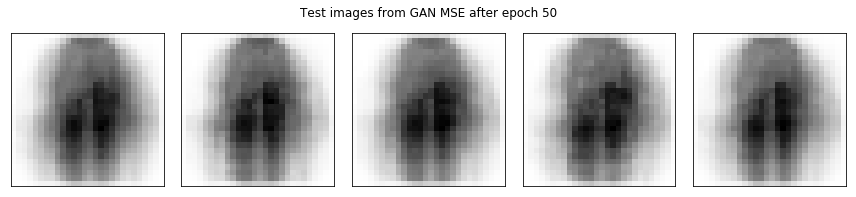

Epoch error:  tensor(0.3529, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3514, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)


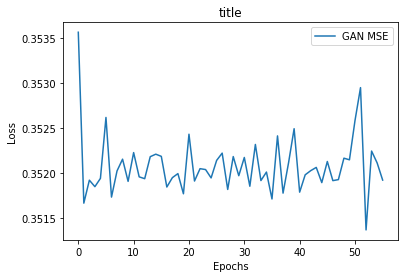

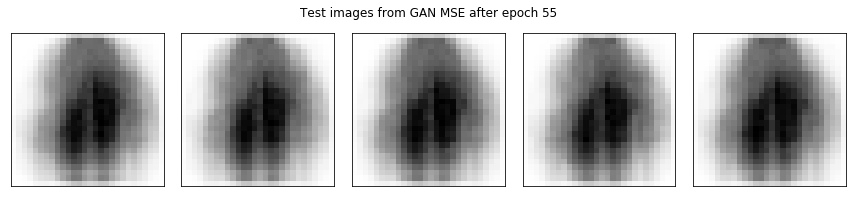

Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3517, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)


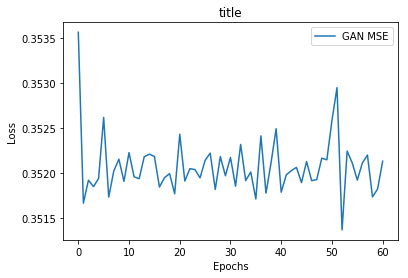

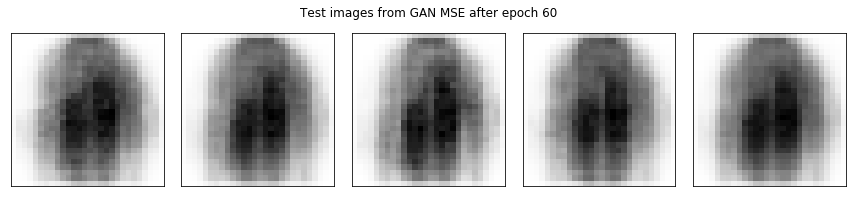

Epoch error:  tensor(0.3524, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3525, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)


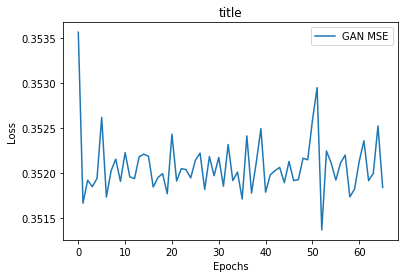

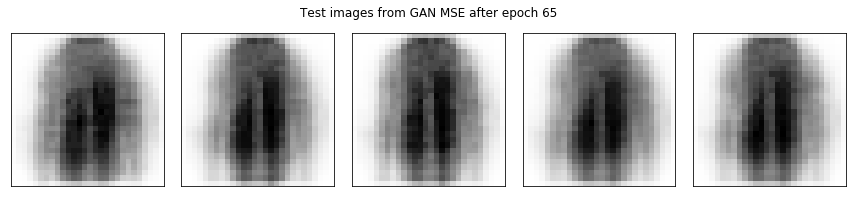

Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)


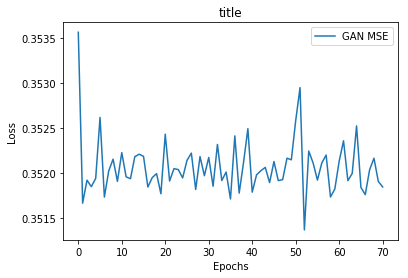

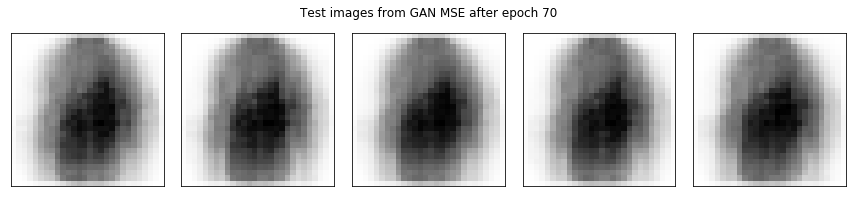

Epoch error:  tensor(0.3533, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3523, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)


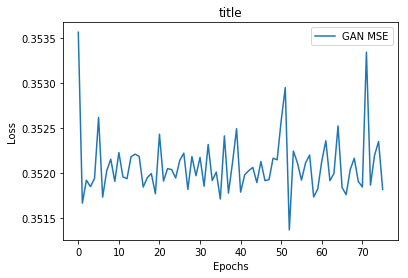

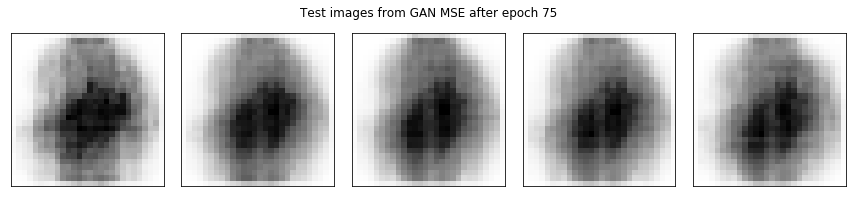

Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)


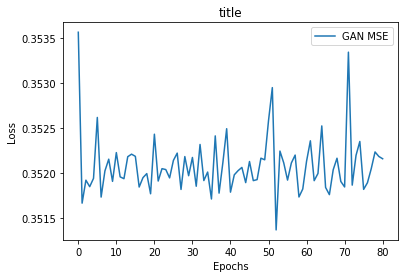

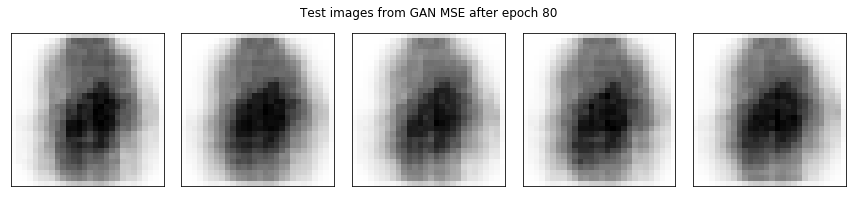

Epoch error:  tensor(0.3517, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3524, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)


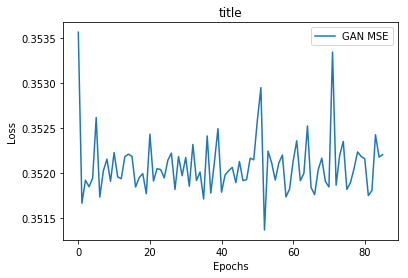

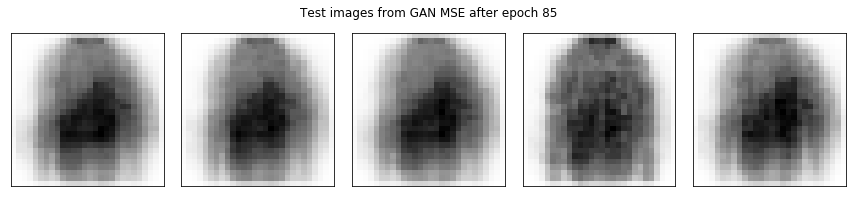

Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3522, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)


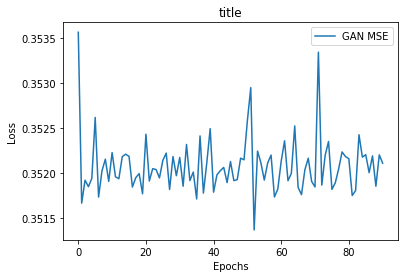

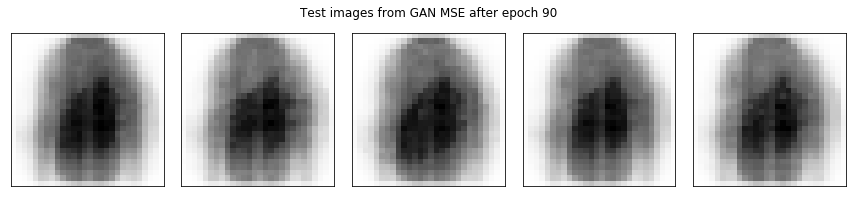

Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)


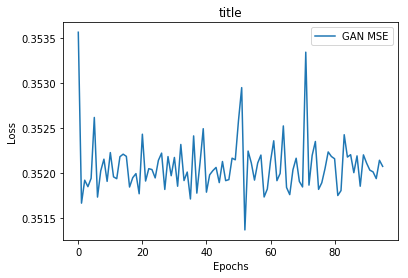

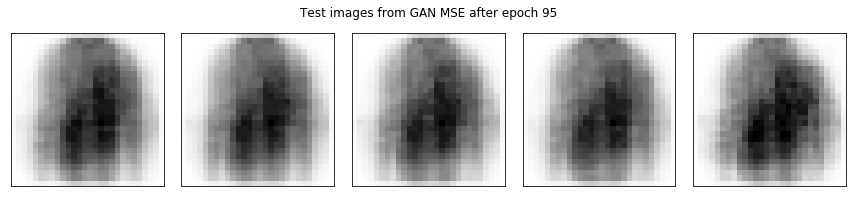

Epoch error:  tensor(0.3519, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3520, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch error:  tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)
Last generator loss - tensor(0.3518, device='cuda:0', grad_fn=<DivBackward0>)


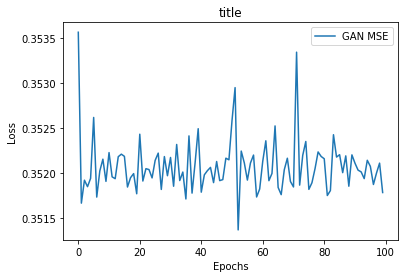

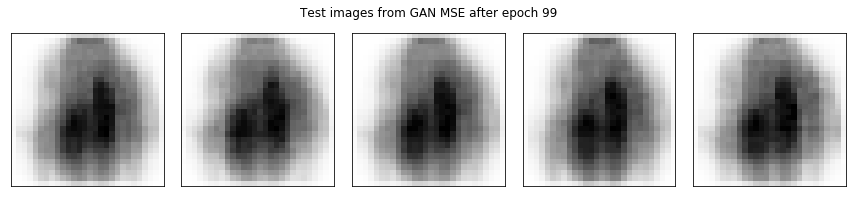

In [23]:
# Function to train the generator
def train_generator_mse(real_data, fake_data):       
    # Calculate error and backpropagate
    train_loss = loss_mse(fake_data, real_data)
    
    # Update generator weights with gradients
    mse_opt.zero_grad()
    train_loss.backward()
    mse_opt.step()

    return train_loss
  
gen_mse = Generator()
gen_mse = gen_mse.to(device)

loss_mse = nn.MSELoss()
mse_opt = optim.Adam(gen_mse.parameters(),lr=0.002)

num_epochs = 100

gen_error_mse = []
  
for epoch in range(num_epochs):
  temp_err = 0.0
  temp_err_cnt = 0 
  
  for n_batch, (real_batch,_) in enumerate(data_loader):
    fake_noise = noise(batch_size)
    fake_data = gen_mse(fake_noise).to(device)    
    real_data = Variable(images_to_vectors(real_batch)).to(device)
    mse_error = train_generator_mse(real_data, fake_data)
    temp_err += mse_error
    temp_err_cnt += 1

  print("Epoch error: ",temp_err/temp_err_cnt)
  gen_error_mse.append(temp_err/temp_err_cnt)
  
  if (epoch) % 5 == 0 or epoch == (num_epochs-1): 
    print("Last generator loss -",gen_error_mse[-1])
    plot_model_errors(gen_error_mse,"GAN MSE")
    show_model_images(5,gen_mse,"GAN MSE",epoch)

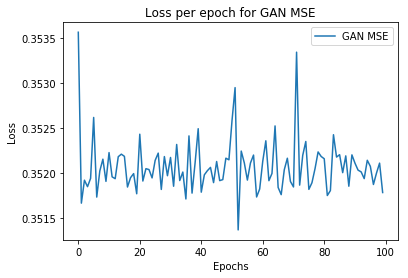

In [27]:
plot_model_errors(gen_error_mse,"GAN MSE")


In [0]:
class WganDiscriminator(torch.nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    n_features = 784
    n_out = 1

    self.hidden0 = nn.Sequential( 
      nn.Linear(n_features, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3)
    )
    self.hidden1 = nn.Sequential(
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3)
    )
    self.hidden2 = nn.Sequential(
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3)
    )
    self.out = nn.Sequential(
      torch.nn.Linear(256, n_out),
      #torch.nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

In [0]:
""" WGAN """
# During discriminator forward-backward-update
W_D_loss = -(torch.mean(D_real) - torch.mean(D_fake))
# During generator forward-backward-update
W_G_loss = -torch.mean(D_fake)

# Function to train the generator
def train_generator_wgan(real_data, fake_data):       
    # Calculate error and backpropagate
    train_loss = -(torch.mean(real_data) - torch.mean(fake_data))
    
    # Update generator weights with gradients
    mse_opt.zero_grad()
    train_loss.backward()
    mse_opt.step()

    return train_loss
  
gen_mse = Generator()
gen_mse = gen_mse.to(device)

loss_mse = nn.MSELoss()
mse_opt = optim.Adam(gen_mse.parameters(),lr=0.002)

num_epochs = 100

gen_error_mse = []
  
for epoch in range(num_epochs):
  temp_err = 0.0
  temp_err_cnt = 0 
  
  for n_batch, (real_batch,_) in enumerate(data_loader):
    fake_noise = noise(batch_size)
    fake_data = gen_mse(fake_noise).to(device)    
    real_data = Variable(images_to_vectors(real_batch)).to(device)
    mse_error = train_generator_mse(real_data, fake_data)
    temp_err += mse_error
    temp_err_cnt += 1

  print("Epoch error: ",temp_err/temp_err_cnt)
  gen_error_mse.append(temp_err/temp_err_cnt)
  
  if (epoch) % 5 == 0 or epoch == (num_epochs-1): 
    print("Last generator loss -",gen_error_mse[-1])
    plot_model_errors(gen_error_mse,"GAN MSE")
    show_model_images(5,gen_mse,"GAN MSE",epoch)

In [0]:
# Modeling drawn from:
# https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py

clip = 0.1

G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)


D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1),
)


def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)


for it in range(100):
    for _ in range(5):
        # Sample data
        z = Variable(torch.randn(mb_size, z_dim))
        X, _ = mnist.train.next_batch(mb_size)
        X = Variable(torch.from_numpy(X))

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-clip, clip)

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    X, _ = mnist.train.next_batch(mb_size)
    X = Variable(torch.from_numpy(X))
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
        plt.close(fig)

## Part 3 - Mode collapse in GANs

In [13]:
# Train the models
# Total number of epochs to train
num_epochs = 1

gen_error = []
disc_error = []

temp_disc_err = 0
temp_gen_err = 0
temp_err_cnt = 0

gen_model = Generator()
disc_model = Discriminator()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Loading models on GPU",device)
gen_model.to(device)
disc_model.to(device)

# Defining loss function and optimizers
#loss = nn.BCELoss()
loss = nn.CrossEntropyLoss()
gen_opt = optim.Adam(gen_model.parameters(), lr=0.0002)
disc_opt = optim.Adam(disc_model.parameters(), lr=0.0002)
 
  
for epoch in range(num_epochs):
  temp_disc_err = 0
  temp_gen_err = 0
  temp_err_cnt = 0
  
  for n_batch, (real_batch, real_label) in enumerate(data_loader):
    print(real_label)
    # train discriminator
    fake_noise = noise(batch_size)
    fake_data = gen_model(fake_noise).to(device)    
    real_data = Variable(images_to_vectors(real_batch)).to(device)
    disc_err = train_discriminator(real_data, fake_data)
    temp_disc_err += disc_err

    # train generator
    #fake_noise = noise(batch_size)      
    #fake_data = gen_model(fake_noise).to(device)
    #gen_err = train_generator(fake_data)
    #temp_gen_err += gen_err
    temp_err_cnt += 1

  disc_error.append(temp_disc_err/temp_err_cnt)
  gen_error.append(temp_gen_err/temp_err_cnt)
  
  if (epoch) % 5 == 0 or epoch == (num_epochs-1): 
    print("Last generator error -",gen_error[-1])
    print("Last discriminator error =",disc_error[-1])
    plot_errors(disc_error,gen_error)
    show_test_images(5,epoch)

Loading models on GPU cuda:0
tensor([0, 9, 3, 5, 2, 2, 7, 5, 4, 4, 8, 0, 8, 7, 6, 1, 7, 6, 3, 6])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20, 10])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: ignored